All i want to do is change an atom's element, after getting it's index from visual inspection

In [1]:
import torch
import prody
import py3Dmol
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit.Chem.Draw import IPythonConsole
Draw.IPythonConsole.ipython_3d = True
import numpy as np
import time
import h5py
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from leadopt.model_conf import LeadoptModel, DIST_FN
from leadopt import grid_util
from leadopt.data_util import REC_TYPER, LIG_TYPER
from leadopt import util

In [ ]:
#first the ligans i have don't have hydrogens, so first protonate
!obabel -isdf 6q4d_B_HHT.sdf -osdf -O Bh.sdf -h

In [ ]:
#SDF edit method
#for some reason obabel replaces BR with *, and i can't get rdkit to show Hs - so just changing all H's to * so they are displayed with indexes
with open('Bh.sdf') as f:
    newText=f.read().replace('*', 'BR').replace('H', '*')

with open('Bh2.sdf', "w") as f:
    f.write(newText)

In [5]:
def mol_with_atom_index(mol):
    atoms = mol.GetNumAtoms()
    tmp_mol = Chem.Mol(mol)
    for idx in range(atoms):
        tmp_mol.GetAtomWithIdx(idx).SetProp('molAtomMapNumber', str(tmp_mol.GetAtomWithIdx(idx).GetIdx()))
    return tmp_mol

In [6]:
def atom_sub(rdkit_mol: Chem.Mol, target_idx: int, new_atom: int) -> Chem.Mol:
    edit_mol = Chem.RWMol(rdkit_mol)
    for atom in edit_mol.GetAtoms():
        if atom.GetIdx() == target_idx:
            atom.SetAtomicNum(new_atom)
    return Chem.Mol(edit_mol)

In [7]:
def to2d(x):
  '''Remove 3d coordinate info from a rdkit mol for display purposes.'''
  return Chem.MolFromSmiles(Chem.MolToSmiles(x, isomericSmiles=False))

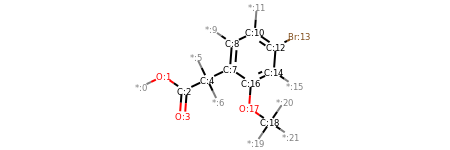

In [8]:
from rdkit.Chem import rdmolops

lig = Chem.MolFromMolFile('./Bh2.sdf')
mol_with_atom_index(to2d(lig))

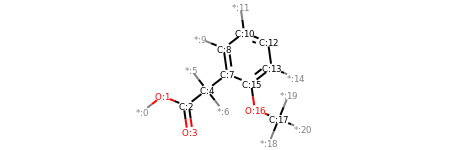

In [9]:
#testing random indexes to see what is what, e.g. 10 is BR since BR is on the 10th line in the SDF file
#replaces BR with H, and Hs arent displayed
#rdkit index for BR is 13
mol_with_atom_index(to2d(atom_sub(lig, 10, 1)))

In [ ]:
#non SDF edit method

#replaces halogen with H
match = Chem.MolFromSmarts('[Br]')
repl = Chem.MolFromSmarts('[H]')
new_mol = Chem.ReplaceSubstructs(lig, match, repl)
new_molH = new_mol[0]

#removes Hs
new_mol = Chem.RemoveHs(new_molH)
new_mol



#combines wildcard with molecule, represented in 2D
combo = Chem.CombineMols(Chem.MolFromSmiles("*"), new_mol)
combo_2d = Chem.Mol(combo)
_ = AllChem.Compute2DCoords(combo_2d)
mol_with_atom_index(combo_2d)

In [ ]:
#atm_idx selects where the exit vector will be
atm_idx = 2
exit_vector = 0
edcombo = Chem.EditableMol(combo)
num_heavy_atoms = combo.GetNumHeavyAtoms()
edcombo.AddBond(atm_idx, exit_vector, order=Chem.rdchem.BondType.ZERO)
editedmol = edcombo.GetMol()
Chem.SanitizeMol(editedmol)
combo_2d = Chem.Mol(editedmol)
_ = AllChem.Compute2DCoords(combo_2d)
lig_new = mol_with_atom_index(combo_2d)
lig_list = [lig_new,lig_new]
mol_with_atom_index(combo_2d)

In [ ]:
The problem with this method is that any added atom has no 3D information, and so is added at (0,0,0)

In [ ]:
So the SDF edit method has problems with finding out the index of the atom you want to swap, and the pure rdkit method has issues with added atoms not containing any 3d information. help.